# Legal RAG evaluation

Evaluates the legal RAG system using the ground truth Q&A dataset.
This notebook tests the RAG pipeline's ability to correctly answer questions based on legal documents.

In [1]:
import json
import re
import time
import textwrap
from typing import Dict, List, Any, Tuple
from tqdm import tqdm
import pandas as pd
import pickle

from legal_rag import LegalRAGBackend
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

## Load ground truth dataset

In [2]:
# Load the factually correct ground truth dataset
with open("qa_list_relevant_and_factual.json", "r") as f:
    ground_truth_qa = json.load(f)

print(f"Loaded {len(ground_truth_qa)} factually correct Q&A pairs")

# Show first example
if ground_truth_qa:
    example = ground_truth_qa[0]
    print(f"\nExample Q&A:")
    print(f"Q: {example['question']}")
    print(f"Correct Answer: {example['correct_answer']} - {example['options'][example['correct_answer']]}")
    print(f"Client: {example.get('client', 'Unknown')}")
    print(f"Document Type: {example.get('document_type', 'Unknown')}")

Loaded 178 factually correct Q&A pairs

Example Q&A:
Q: Under what conditions can either party assign their rights and obligations under this agreement?
Correct Answer: A - Without consent if assigning to a successor of substantially all business assets.
Client: Ochsner Health System
Document Type: unknown


## Initialize RAG backend

In [3]:
AZURE_OPENAI_ENDPOINT = "https://ironclad-openai-001.openai.azure.com/"
AZURE_OPENAI_API_KEY = "936856630b764210913d9a8fd6c8212b"
AZURE_DEPLOYMENT_NAME = "gpt-4o"

rag_backend = LegalRAGBackend()


azure_llm = AzureChatOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    api_version="2023-05-15",
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_deployment=AZURE_DEPLOYMENT_NAME,
    temperature=0.0
)

In [4]:
test_text = "What are the data retention requirements?"
print(f"Testing embedding for: {test_text}")

try:
    embedding = rag_backend.get_text_embedding(test_text)
    if embedding is None:
        print("❌ Embedding is None - there's an issue with the embedding service")
    else:
        print(f"✅ Embedding generated successfully: {len(embedding)} dimensions")
        print(f"First 5 values: {embedding[:5]}")
        
        # Test a simple RAG query to check vector store
        print("\nTesting basic RAG query...")
        rag_response, refs, latency, chunks = rag_backend.run_query_pipeline_langchain(
            query="What are data retention requirements?",
            top_k=3
        )
        
        if rag_response:
            print(f"✅ RAG query successful, latency: {latency}ms")
            print(f"Response length: {len(rag_response)} chars")
            print(f"Number of chunks: {len(chunks)}")
        else:
            print("❌ RAG query failed")
            
except Exception as e:
    print(f"❌ Error: {e}")
    print("\n💡 Try restarting the kernel to reload the updated legal_rag.py file")

Testing embedding for: What are the data retention requirements?
✅ Embedding generated successfully: 384 dimensions
First 5 values: [-0.07822941988706589, 0.04103412479162216, 0.02099984511733055, -0.03353564813733101, -0.039449408650398254]

Testing basic RAG query...
✅ RAG query successful, latency: 3242.27ms
Response length: 1518 chars
Number of chunks: 3


## RAG evaluation functions

In [5]:
import json

def escape_curly_braces(text: str) -> str:
    """Helper function to escape curly braces for f-string formatting."""
    text = str(text)
    return text.replace("{", "{{").replace("}", "}}")


def _parse_llm_response(response_text):
    response_text = re.sub(r'\\u[0-9a-fA-F]{4}', '', response_text)
    dict_match = re.search(r'\{[^}]*"correct_answer"[^}]*\}', response_text, re.DOTALL)
    if dict_match:
        response_text = dict_match.group(0)
    try:
        return json.loads(response_text)
    except Exception:
        try:
            return json.loads(response_text.replace("'", '"'))
        except Exception:
            try:
                return eval(response_text)
            except Exception:
                return None


def extract_answer_from_rag(rag_response: str, options: Dict[str, str]) -> str:
    """
    Extract the most likely answer choice (A, B, C, D) from RAG response
    using LLM evaluation approach.
    """
    if not rag_response or not options:
        return "unknown"
    
    # Create question dictionary for LLM evaluation
    question_dict = {
        "context": rag_response,
        "question": "Based on the context above, which of the following options is correct?",
        "options": options
    }
    
    system_prompt = textwrap.dedent(f"""
        You are an expert at answering multiple-choice questions using only the information from a context. If you cant find the answer in the context, just say that you DO NOT KNOW.

        Your output should be a python dictionary like the following structure:

        {escape_curly_braces({
            "correct_answer": "give your answer", 
            "explanation": "give a brief explanation of your answer"})}

        For example:

        {escape_curly_braces({
            "correct_answer": "C",
            "explanation": "The configuration is for the file system and kernels in a SageMaker image running as a KernelGateway app."
        })}
        
        ONLY output the requested dictionary.
        """)
    
    human_prompt = textwrap.dedent(f"""
        Answer the following multiple-choice question:
        
        {escape_curly_braces(question_dict)}
        """)
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_prompt),
    ])

    try:
        chain = prompt | azure_llm
        output = chain.invoke({})
        response_dict = _parse_llm_response(output.content.strip())
        if isinstance(response_dict, dict) and 'correct_answer' in response_dict:
            answer = response_dict['correct_answer'].strip().upper()
            if answer in options:
                return answer
            if "do not know" in answer.lower():
                return "unknown"
            letter_match = re.search(r'[ABCD]', answer)
            if letter_match and letter_match.group(0) in options:
                return letter_match.group(0)
        return "unknown"
    except Exception:
        return "unknown"


def get_rag_answer(qa_item: Dict[str, Any]) -> Tuple[str, str, float]:
    """
    Get RAG answer for a Q&A item.
    Returns (predicted_answer, rag_response, latency)
    """
    question = qa_item['question']
    options = qa_item['options']
    client = qa_item.get('client')
    document_type = qa_item.get('document_type')
    
    # Format the question with options for the RAG system
    formatted_question = f"{question}\n\nOptions:\n"
    for key, value in options.items():
        formatted_question += f"{key}: {value}\n"
    formatted_question += "\nPlease select the correct answer (A, B, C, or D) and explain your reasoning."
    
    try:
        # Query the RAG system
        rag_response, refs, latency, chunks = rag_backend.run_query_pipeline_langchain(
            query=formatted_question,
            client_filter=client if client != "All" else None,
            document_type_filter=document_type if document_type != "All" else None,
            top_k=5
        )
        
        if rag_response:
            predicted_answer = extract_answer_from_rag(rag_response, options)
            return predicted_answer, rag_response, latency
        return "unknown", "No response from RAG system", 0
    except Exception as e:
        return "unknown", f"Error: {str(e)}", 0


def evaluate_answers_with_unknowns(predictions: List[str], ground_truth: List[str]) -> Dict[str, float]:
    """
    Evaluate predictions against ground truth, handling unknown predictions.
    """
    if len(predictions) != len(ground_truth):
        raise ValueError("Predictions and ground truth must have the same length")
    
    total = len(predictions)
    correct = sum(1 for pred, gt in zip(predictions, ground_truth) if pred == gt)
    unknown = sum(1 for pred in predictions if pred == "unknown")
    incorrect = total - correct - unknown
    
    metrics = {
        "accuracy": correct / total if total > 0 else 0,
        "correct_count": correct,
        "incorrect_count": incorrect,
        "unknown_count": unknown,
        "total_count": total,
        "answerable_accuracy": correct / (total - unknown) if (total - unknown) > 0 else 0,
        "coverage": (total - unknown) / total if total > 0 else 0
    }
    
    return metrics


def get_llm_only_answer(qa_item: Dict[str, Any]) -> Tuple[str, str, float]:
    """
    Get LLM-only answer for a Q&A item (without RAG context).
    Returns (predicted_answer, llm_response, latency)
    """
    question = qa_item['question']
    options = qa_item['options']
    
    # Format the question with options for direct LLM answering
    formatted_question = f"{question}\n\nOptions:\n"
    for key, value in options.items():
        formatted_question += f"{key}: {value}\n"
    formatted_question += "\nPlease select the correct answer (A, B, C, or D) and explain your reasoning."
    
    system_prompt = textwrap.dedent(f"""
        You are an expert at answering multiple-choice questions about legal documents and data usage policies. 
        Use your general knowledge about legal practices, data privacy, and contractual obligations.
        If you are not confident about the answer based on general legal knowledge, say "DO NOT KNOW".

        Your output should be a python dictionary like the following structure:

        {escape_curly_braces({
            "correct_answer": "give your answer", 
            "explanation": "give a brief explanation of your answer"})}

        For example:

        {escape_curly_braces({
            "correct_answer": "C",
            "explanation": "Based on general legal practices, this is typically the standard requirement."
        })}
        
        ONLY output the requested dictionary.
        """)
    
    human_prompt = textwrap.dedent(f"""
        Answer the following multiple-choice question using your general legal knowledge:
        
        {escape_curly_braces(formatted_question)}
        """)
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_prompt),
    ])

    try:
        start_time = time.time()
        chain = prompt | azure_llm
        output = chain.invoke({})
        latency = round((time.time() - start_time) * 1000, 2)
        response_dict = _parse_llm_response(output.content.strip())
        if isinstance(response_dict, dict) and 'correct_answer' in response_dict:
            answer = response_dict['correct_answer'].strip().upper()
            full_response = f"Answer: {answer}\nExplanation: {response_dict.get('explanation', 'No explanation provided')}"
            if answer in options:
                return answer, full_response, latency
            if "do not know" in answer.lower():
                return "unknown", full_response, latency
            letter_match = re.search(r'[ABCD]', answer)
            if letter_match and letter_match.group(0) in options:
                return letter_match.group(0), full_response, latency
        return "unknown", "Could not parse LLM response", latency
    except Exception as e:
        return "unknown", f"Error: {str(e)}", 0


def get_rag_cot_answer(qa_item: Dict[str, Any]) -> Tuple[str, str, float]:
    """
    Get RAG Chain-of-Thought answer for a Q&A item.
    Returns (predicted_answer, rag_response, latency)
    """
    question = qa_item['question']
    options = qa_item['options']
    client = qa_item.get('client')
    document_type = qa_item.get('document_type')
    
    formatted_question = f"{question}\n\nOptions:\n"
    for key, value in options.items():
        formatted_question += f"{key}: {value}\n"
    formatted_question += "\nPlease select the correct answer (A, B, C, or D) and explain your reasoning."
    
    try:
        rag_response, refs, latency, chunks = rag_backend.run_query_pipeline_cot(
            query=formatted_question,
            client_filter=client if client != "All" else None,
            document_type_filter=document_type if document_type != "All" else None,
            top_k=5
        )
        
        if rag_response:
            predicted_answer = extract_answer_from_rag(rag_response, options)
            return predicted_answer, rag_response, latency
        return "unknown", "No response from RAG system", 0
    except Exception as e:
        return "unknown", f"Error: {str(e)}", 0



## Run RAG, LLM-only, and RAG-CoT evaluations

Compare three methods: RAG, LLM-only, and RAG with Chain-of-Thought

In [6]:
ground_truth_qa[:2]

[{'question': 'Under what conditions can either party assign their rights and obligations under this agreement?',
  'options': {'A': 'Without consent if assigning to a successor of substantially all business assets.',
   'B': 'Without consent if the agreement is executed in counterparts.',
   'C': 'With consent only if the assignment is for less than half of the obligations.',
   'D': 'With prior written consent from the other party.'},
  'correct_answer': 'A',
  'explanation': 'Either party can assign their rights and obligations under the agreement to a successor in ownership of substantially all of the assets of the business, provided that the successor expressly assumes in writing the performance of the terms and conditions of the agreement.',
  'source': 'unknown',
  'client': 'Ochsner Health System',
  'document_type': 'unknown',
  'context': 'BH 546 \nNew Or leans, LA 70121  \nAttn: Scott Posecai  \n \nwith a copy to:   Office of Legal Affairs  \nOchsner Health Plan  \n1450 Poyd

In [8]:
print(f"Starting comparative evaluation on {len(ground_truth_qa)} questions...\n")

def run_method_evaluation(method_name, answer_fn, qa_list):
    results, predictions, ground_truth = [], [], []
    for i, qa_item in enumerate(tqdm(qa_list, desc=f"Evaluating {method_name}")):
        correct = qa_item['correct_answer']
        ground_truth.append(correct)
        pred, resp, latency = answer_fn(qa_item)
        predictions.append(pred)
        result = {
            "id": qa_item['id'],
            "question": qa_item['question'],
            "options": qa_item['options'],
            "correct_answer": correct,
            "predicted_answer": pred,
            "is_correct": pred == correct,
            "response": resp,
            "latency_ms": latency,
            "client": qa_item.get('client', 'Unknown'),
            "document_type": qa_item.get('document_type', 'Unknown'),
            "method": method_name
        }
        results.append(result)
        time.sleep(1)
    return results, predictions, ground_truth

def get_rag_answer_no_filter(qa_item: Dict[str, Any]) -> Tuple[str, str, float]:
    question = qa_item['question']
    options = qa_item['options']
    
    formatted_question = f"{question}\n\nOptions:\n"
    for key, value in options.items():
        formatted_question += f"{key}: {value}\n"
    formatted_question += "\nPlease select the correct answer (A, B, C, or D) and explain your reasoning."
    
    try:
        rag_response, refs, latency, chunks = rag_backend.run_query_pipeline_langchain(
            query=formatted_question,
            top_k=5
        )
        
        if rag_response:
            predicted_answer = extract_answer_from_rag(rag_response, options)
            return predicted_answer, rag_response, latency
        return "unknown", "No response from RAG system", 0
    except Exception as e:
        return "unknown", f"Error: {str(e)}", 0

def get_rag_cot_answer_no_filter(qa_item: Dict[str, Any]) -> Tuple[str, str, float]:
    question = qa_item['question']
    options = qa_item['options']
    
    formatted_question = f"{question}\n\nOptions:\n"
    for key, value in options.items():
        formatted_question += f"{key}: {value}\n"
    formatted_question += "\nPlease select the correct answer (A, B, C, or D) and explain your reasoning."
    
    try:
        rag_response, refs, latency, chunks = rag_backend.run_query_pipeline_cot(
            query=formatted_question,
            top_k=5
        )
        
        if rag_response:
            predicted_answer = extract_answer_from_rag(rag_response, options)
            return predicted_answer, rag_response, latency
        return "unknown", "No response from RAG system", 0
    except Exception as e:
        return "unknown", f"Error: {str(e)}", 0

rag_results, rag_predictions, ground_truth_answers = run_method_evaluation("RAG", get_rag_answer_no_filter, ground_truth_qa)
llm_only_results, llm_only_predictions, _ = run_method_evaluation("LLM-only", get_llm_only_answer, ground_truth_qa)
rag_cot_results, rag_cot_predictions, _ = run_method_evaluation("RAG-CoT", get_rag_cot_answer_no_filter, ground_truth_qa)

print(f"\ncompleted comparative evaluation of {len(ground_truth_qa)} questions")

Starting comparative evaluation on 178 questions...



Evaluating RAG-CoT:   0%|          | 0/178 [00:00<?, ?it/s]


🔍 Running Chain-of-Thought RAG query for: Under what conditions can either party assign their rights and obligations under this agreement?

Options:
A: Without consent if assigning to a successor of substantially all business assets.
B: Without consent if the agreement is executed in counterparts.
C: With consent only if the assignment is for less than half of the obligations.
D: With prior written consent from the other party.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   1%|          | 1/178 [00:04<12:10,  4.13s/it]


🔍 Running Chain-of-Thought RAG query for: What is the primary restriction on the use and disclosure of Confidential Information under the NDA between ATRIO Health Plans and the Receiving Party?

Options:
A: Confidential Information must be shared with all employees.
B: Confidential Information can only be used in relation to the Potential Transaction.
C: Confidential Information can be used for any business purpose.
D: Confidential Information can be disclosed to third parties without permission.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   1%|          | 2/178 [00:08<13:04,  4.46s/it]


🔍 Running Chain-of-Thought RAG query for: What rights does the Business Associate Agreement (BAA) provide regarding individuals' protected health information?

Options:
A: The right to obtain a copy of information in an electronic format.
B: The right to terminate the agreement with immediate effect.
C: The right to receive compensation for disclosed information.
D: The right to audit and monitor financial transactions.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   2%|▏         | 3/178 [00:13<13:12,  4.53s/it]


🔍 Running Chain-of-Thought RAG query for: What is the non-competition clause in the agreement?

Options:
A: Licensee cannot develop similar products during the term and one year after termination.
B: Licensee cannot publicly disclose the commercial relationship with Licensor.
C: Licensee can hire third parties to develop similar products during the agreement.
D: Licensee can develop similar products immediately after termination.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   2%|▏         | 4/178 [00:16<11:55,  4.11s/it]


🔍 Running Chain-of-Thought RAG query for: What is required before Cotiviti can use offshore subcontractors or employees to access PHI?

Options:
A: Cotiviti must receive client approval
B: Cotiviti must notify the client 30 days in advance
C: No approval is necessary
D: Cotiviti must provide detailed records of access

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   3%|▎         | 5/178 [00:19<10:36,  3.68s/it]


🔍 Running Chain-of-Thought RAG query for: Which type of incident does NOT require Response and Reporting measures according to section 1.1.9?

Options:
A: Service attacks that do not result in a server being taken offline
B: Introduction of malware that does not result in unauthorized access
C: Unauthorized acquisition of BSC Data
D: Invalid password attempts

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   3%|▎         | 6/178 [00:23<10:26,  3.64s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances is the Business Associate allowed to receive remuneration in exchange for PHI?

Options:
A: Without any restrictions.
B: Only for marketing purposes.
C: Only with prior written consent of MPHC and as permitted by the HITECH Act.
D: For payment related to health care operations regardless of consent.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   4%|▍         | 7/178 [00:26<09:48,  3.44s/it]


🔍 Running Chain-of-Thought RAG query for: Under the MSA, which circumstance requires Cotiviti to indemnify ACA Health Benefits Fund?

Options:
A: Non-payment of Fees by Client
B: Failure to maintain Required Insurance
C: Consequential Loss caused by Cotiviti
D: Wilful Misconduct or Gross Negligence by Cotiviti

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   4%|▍         | 8/178 [00:30<10:01,  3.54s/it]


🔍 Running Chain-of-Thought RAG query for: What is required of the Receiving Party upon termination of the agreement concerning Confidential Information?

Options:
A: Transfer all Confidential Information to a third-party for safekeeping.
B: Destroy or deliver all Confidential Information to the Disclosing Party, except for a single archival copy.
C: Return all Confidential Information without retaining any copies.
D: Retain all electronic and digital copies of Confidential Information indefinitely.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   5%|▌         | 9/178 [00:33<09:52,  3.51s/it]


🔍 Running Chain-of-Thought RAG query for: Which clause describes the effect of a force majeure event on the Licensor’s performance?

Options:
A: Licensor’s performance is terminated and considered a default
B: Licensor must renegotiate terms with Licensee
C: Licensor’s performance is excused and the time for performance is extended
D: Licensor must continue performance without delay

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   6%|▌         | 10/178 [00:37<10:10,  3.63s/it]


🔍 Running Chain-of-Thought RAG query for: What does the agreement state regarding the creation of formal business relationships between the parties?

Options:
A: There is no obligation to enter into a formal business organization.
B: The parties must share profits and liabilities.
C: The parties are bound to enter into a partnership.
D: The agreement establishes a joint venture.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   6%|▌         | 11/178 [00:41<10:06,  3.63s/it]


🔍 Running Chain-of-Thought RAG query for: What must the Receiving Party do with Confidential Information upon termination of the Agreement or upon written request from the Disclosing Party?

Options:
A: Retain all copies for future reference
B: Deliver all copies to the Disclosing Party
C: Distribute copies to relevant departments for processing
D: Destroy all documents and materials except a single archival copy for legal purposes

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   7%|▋         | 12/178 [00:44<10:13,  3.70s/it]


🔍 Running Chain-of-Thought RAG query for: What remedy is available to the Disclosing Party for a breach of the agreement?

Options:
A: Termination of the agreement
B: Money damages only
C: Arbitration
D: Specific performance and/or injunctive relief

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   7%|▋         | 13/178 [00:48<09:43,  3.54s/it]


🔍 Running Chain-of-Thought RAG query for: What actions must be taken if a party becomes aware of a data breach according to the MSA?

Options:
A: Notify the regulatory authorities immediately and cease communication with the other party.
B: Delay notifying the other party until a full investigation is complete.
C: Promptly notify the other party and meet to discuss the next steps regarding investigation and handling of the breach.
D: Promptly notify the other party and then handle the breach independently.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   8%|▊         | 14/178 [00:52<10:03,  3.68s/it]


🔍 Running Chain-of-Thought RAG query for: Under the NDA, when do the obligations regarding Confidential Information cease to apply?

Options:
A: When the receiving party independently develops the information without reference to the Confidential Information
B: When the receiving party sells the information to a competitor
C: When the information is disclosed to a third party
D: When the receiving party uses the information for its own purposes

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   8%|▊         | 15/178 [00:56<10:45,  3.96s/it]


🔍 Running Chain-of-Thought RAG query for: What is the permitted use of Confidential Information under the NDA?

Options:
A: To reverse engineer prototypes to improve own products.
B: To disclose to third parties for marketing purposes.
C: To evaluate a business relationship with the disclosing party.
D: To develop new products independently.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:   9%|▉         | 16/178 [01:00<10:31,  3.90s/it]


🔍 Running Chain-of-Thought RAG query for: What is included in the Technical Specification Document according to the Work Order / Change Request?

Options:
A: Only Roles and Responsibilities
B: System Access Requirements and Data Mapping Requirements
C: Functional and Technical Design Requirements such as Scope and Business Parameters
D: B and C are both included

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  10%|▉         | 17/178 [01:03<09:56,  3.71s/it]


🔍 Running Chain-of-Thought RAG query for: What is the duration of the confidentiality obligations after the expiration or termination of the agreement?

Options:
A: 1 year after the Effective Date
B: 3 years after the Effective Date
C: Until the agreement is terminated
D: 2 years after the Effective Date

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  10%|█         | 18/178 [01:07<09:46,  3.67s/it]


🔍 Running Chain-of-Thought RAG query for: What is permitted regarding the use of Confidential Information according to the agreement?

Options:
A: Using it in competitive products without restrictions
B: Using it for product development without restrictions
C: Sharing it freely with all employees
D: Using it for any third party’s benefit with prior written approval

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  11%|█         | 19/178 [01:11<09:59,  3.77s/it]


🔍 Running Chain-of-Thought RAG query for: What does the Miscellaneous section of the MSA state regarding reliance on representations?

Options:
A: Parties can rely on written representations made after the Agreement.
B: Parties can rely on inducements from third parties.
C: Parties cannot rely on any representations outside of those expressly contained within the Agreement.
D: Parties can rely on oral representations made before the Agreement.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  11%|█         | 20/178 [01:15<09:49,  3.73s/it]


🔍 Running Chain-of-Thought RAG query for: What restrictions are placed on the use of Confidential Information according to the NDA with 7-Eleven?

Options:
A: It must only be used for evaluating the Potential Transaction and cannot be disclosed without prior written consent.
B: It can only be used for marketing purposes related to the Potential Transaction.
C: It can be used for any commercial purpose as long as it remains confidential.
D: It can be shared with any third party if they agree to confidentiality.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  12%|█▏        | 21/178 [01:20<10:53,  4.16s/it]


🔍 Running Chain-of-Thought RAG query for: What does the NDA specify about the ownership of Confidential Information?

Options:
A: Confidential Information becomes joint property of both parties.
B: Ownership of Confidential Information is transferred to the Receiving Party.
C: The Receiving Party gains partial ownership of the Confidential Information.
D: Confidential Information remains the sole property of the Disclosing Party.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  12%|█▏        | 22/178 [01:24<10:36,  4.08s/it]


🔍 Running Chain-of-Thought RAG query for: What actions must the contractor take when receiving a request for access or amendment of PHI?

Options:
A: Amend the PHI directly without involving HHS.
B: Promptly forward the request to HHS or notify HHS if forwarding violates HIPAA.
C: Immediately respond to the request without notifying HHS.
D: Forward the request to the individual who made it.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  13%|█▎        | 23/178 [01:27<10:10,  3.94s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances can Community First request Business Associate to use or disclose PHI?

Options:
A: In any manner deemed necessary by Community First
B: In any manner that enhances business operations
C: Only in ways permissible under the Privacy Rule
D: Only for marketing purposes

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  13%|█▎        | 24/178 [01:31<09:43,  3.79s/it]


🔍 Running Chain-of-Thought RAG query for: What rights does the Business Associate have regarding the ownership of PHI?

Options:
A: The Business Associate shares ownership rights of PHI with MPHC
B: The Business Associate can acquire ownership rights to PHI after fulfilling obligations
C: The Business Associate has full ownership rights to PHI
D: The Business Associate has no ownership rights to PHI

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  14%|█▍        | 25/178 [01:34<09:07,  3.58s/it]


🔍 Running Chain-of-Thought RAG query for: What is the requirement for data destruction of ACS PHI or PI according to Accenture's BAA?

Options:
A: Data must be wiped using the US Department of Defense (DoD) 5220.22-M standard only.
B: Data must be wiped using the Gutmann standard or US Department of Defense (DoD) 5220.22-M (7 Pass) standard, or by degaussing.
C: Data must be stored indefinitely without destruction.
D: Data can be destroyed using any method without prior approval.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  15%|█▍        | 26/178 [01:38<09:24,  3.71s/it]


🔍 Running Chain-of-Thought RAG query for: According to the document, how often can audits be conducted to ensure compliance with Data Protection Laws?

Options:
A: Annually
B: Monthly
C: Biannually
D: Quarterly

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  15%|█▌        | 27/178 [01:41<08:51,  3.52s/it]


🔍 Running Chain-of-Thought RAG query for: What is the duration of the Nondisclosing Party’s obligations for Confidential Information that constitutes a trade secret under applicable law according to the NDA?

Options:
A: Three years after disclosure
B: Indefinitely regardless of trade secret status
C: For as long as the information remains a trade secret under applicable law
D: Until all agreements between the Parties are terminated

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  16%|█▌        | 28/178 [01:44<08:24,  3.36s/it]


🔍 Running Chain-of-Thought RAG query for: What must the Receiving Party do with Confidential Information upon termination of the agreement or upon request from the Disclosing Party?

Options:
A: Retain all documents and materials for future reference.
B: Destroy or deliver all documents and materials, except for a single archival copy retained by the legal department.
C: Store all documents and materials indefinitely on backup media.
D: Convert all documents and materials into non-confidential information.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  16%|█▋        | 29/178 [01:48<08:36,  3.47s/it]


🔍 Running Chain-of-Thought RAG query for: Under what conditions can a party assign its rights and obligations under this agreement without prior written consent from the other party?

Options:
A: Assignment is allowed if the successor in ownership expressly assumes the agreement terms in writing.
B: Assignment can occur freely without any conditions.
C: Assignment is never allowed without prior written consent.
D: Assignment is allowed only if both parties agree verbally.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  17%|█▋        | 30/178 [01:51<08:44,  3.55s/it]


🔍 Running Chain-of-Thought RAG query for: What is required before a Provider can file a legal proceeding against Blue Cross and Blue Shield of Nebraska?

Options:
A: A peer-to-peer discussion involving the Provider, Client, and Cotiviti
B: Cotiviti providing testimony at State Fair Hearings
C: Immediate filing without any discussions
D: Approval of process documented via email

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  17%|█▋        | 31/178 [01:55<08:30,  3.47s/it]


🔍 Running Chain-of-Thought RAG query for: Under the agreement, how may the Receiving Party use the Disclosing Party's Confidential Information?

Options:
A: For personal use
B: Only for exercising rights and performing obligations related to the Potential Transaction
C: For disclosure to any Third Party without restriction
D: For any business purpose

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  18%|█▊        | 32/178 [01:58<08:15,  3.39s/it]


🔍 Running Chain-of-Thought RAG query for: What is required from Vendor and/or Consultant when accessing the benefit administration systems?

Options:
A: Use commercially reasonable security measures
B: Share their access with other entities
C: Ignore the Company’s security measures
D: Transfer their access rights to another party

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  19%|█▊        | 33/178 [02:01<08:20,  3.45s/it]


🔍 Running Chain-of-Thought RAG query for: Under the MSA agreement, to whom may the Client disclose Confidential Information, and under what conditions?

Options:
A: To any third party without restrictions
B: To employees of Advantmed India LLP and Optum Health – CDO with specific conditions
C: Only to Optum Health – CDO with no conditions
D: To any subcontractors without any prior permissions

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  19%|█▉        | 34/178 [02:05<08:37,  3.60s/it]


🔍 Running Chain-of-Thought RAG query for: What must occur when either party becomes aware of a data breach according to the MSA?

Options:
A: The party must promptly notify the other party and meet to discuss next steps.
B: The party must immediately fix the breach without notifying the other party.
C: The party must ensure all personnel are informed of the breach before notifying the other party.
D: The party must notify the regulatory authorities before informing the other party.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  20%|█▉        | 35/178 [02:09<08:36,  3.61s/it]


🔍 Running Chain-of-Thought RAG query for: What is the requirement for Business Associate when receiving a request, subpoena, or order to disclose PHI?

Options:
A: Business Associate must notify Covered Entity within 30 days.
B: Business Associate must notify Covered Entity within 5 days.
C: Business Associate must challenge the validity independently.
D: Business Associate must comply immediately without notification.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  20%|██        | 36/178 [02:12<08:20,  3.52s/it]


🔍 Running Chain-of-Thought RAG query for: What is the Receiving Party required to do with the Confidential Information upon request by the Disclosing Party?

Options:
A: Retain all Confidential Information but cease its use.
B: Destroy all Confidential Information except automatically generated backups.
C: Destroy all copies, including automatically generated backups.
D: Continue using Confidential Information but with increased security measures.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  21%|██        | 37/178 [02:16<08:36,  3.67s/it]


🔍 Running Chain-of-Thought RAG query for: What rights are included in the Business Associate Agreement regarding individuals' protected health information?

Options:
A: The right to obtain PHI in a paper format only
B: The right to audit and monitor activities involving PHI
C: The right to prevent any disclosure of PHI
D: The right to delete personal information permanently

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  21%|██▏       | 38/178 [02:21<09:06,  3.90s/it]


🔍 Running Chain-of-Thought RAG query for: How is Confidential Information defined in the agreement between the Parties?

Options:
A: Information shared only through electronic communication.
B: Only information shared in written form marked as confidential.
C: Only Proprietary Information and Third Party Information explicitly marked as confidential.
D: All non-public information concerning the Disclosing Party or its business, including oral, visual, written, electronic, or other forms.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  22%|██▏       | 39/178 [02:24<08:44,  3.77s/it]


🔍 Running Chain-of-Thought RAG query for: What is the duration of the Nondisclosing Party’s obligations concerning Confidential Information that is considered a trade secret under the NDA?

Options:
A: Until the Confidential Information no longer constitutes a trade secret
B: Three (3) years after disclosure
C: Until the termination of all agreements between the Parties
D: Indefinitely

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  22%|██▏       | 40/178 [02:27<08:08,  3.54s/it]


🔍 Running Chain-of-Thought RAG query for: What must Vendor and Consultant do with Proprietary Information at the conclusion of services?

Options:
A: Relinquish or destroy the information
B: Store the information securely for 5 years
C: Share the information with authorized third parties
D: Transfer ownership to Employer

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  23%|██▎       | 41/178 [02:31<08:32,  3.74s/it]


🔍 Running Chain-of-Thought RAG query for: Under what conditions can the Recipient disclose Confidential Information?

Options:
A: If the Recipient has prior knowledge before receiving it from the Owner
B: If required by law, with prompt notification to the Owner
C: If the information becomes generally known by third parties
D: If the information is independently developed by the Recipient

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  24%|██▎       | 42/178 [02:35<08:37,  3.80s/it]


🔍 Running Chain-of-Thought RAG query for: What does the term "Sensitive Personal Information" include according to the document?

Options:
A: First name or initial and last name with credit card information
B: Only driver’s license number
C: Just the social security number
D: Any combination of first name and last name

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  24%|██▍       | 43/178 [02:39<08:18,  3.69s/it]


🔍 Running Chain-of-Thought RAG query for: What security measures must COMPANY implement for network security according to the document?

Options:
A: Utilizing only wireless connections without firewalls
B: Using a switched-network topology without password protection
C: Establishing thresholds and alarms to notify personnel of potential problems or outages
D: Allowing unrestricted access to network scan results

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  25%|██▍       | 44/178 [02:44<08:59,  4.02s/it]


🔍 Running Chain-of-Thought RAG query for: What rights are provided to individuals under the BAA regarding their protected health information?

Options:
A: The right to transmit their information to another entity or person
B: The right to delete their information permanently
C: The right to receive compensation for data usage
D: The right to obtain a copy of information in paper format

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  25%|██▌       | 45/178 [02:48<09:00,  4.06s/it]


🔍 Running Chain-of-Thought RAG query for: What requirement must be met before the disclosure of PHI to a Business Associate as per the HIPAA Privacy Rule?

Options:
A: Business Associate must undergo a HIPAA compliance audit.
B: Business Associate must sign a contract containing specific requirements.
C: Business Associate must provide proof of data encryption.
D: Business Associate must be registered with the U.S. Department of Health and Human Services.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  26%|██▌       | 46/178 [02:52<08:50,  4.02s/it]


🔍 Running Chain-of-Thought RAG query for: What is the main purpose of the Work Order (WO) #1 executed between Cotiviti, Inc. and the 1199 SEIU National Benefit Funds?

Options:
A: To outline the process for data interface between the Client and Cotiviti.
B: To provide payment details and deadlines for services rendered.
C: To confirm legal binding and execution of signatures.
D: To establish roles and responsibilities for IT deliverables.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  26%|██▋       | 47/178 [02:55<08:29,  3.89s/it]


🔍 Running Chain-of-Thought RAG query for: What must the Receiving Party do with Confidential Information upon termination of the agreement or upon Disclosing Party’s request?

Options:
A: Retain all Confidential Information indefinitely
B: Backup all Confidential Information and delete all original copies
C: Transfer all Confidential Information to a third party
D: Destroy or return all Confidential Information, except for a single archival copy for dispute resolution

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  27%|██▋       | 48/178 [02:59<08:27,  3.91s/it]


🔍 Running Chain-of-Thought RAG query for: Which of the following is considered "Confidential Information" according to the NDA?

Options:
A: Publicly available marketing strategies
B: General industry knowledge
C: Information disclosed before the Effective Date
D: Pricing and terms under agreements

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  28%|██▊       | 49/178 [03:04<09:07,  4.24s/it]


🔍 Running Chain-of-Thought RAG query for: Under the NDA between Abarca Health LLC and Cotiviti, Inc., what is the status of ownership of the Confidential Information?

Options:
A: Ownership rights are shared equally between both parties.
B: The Receiving Party gains joint ownership with the Disclosing Party.
C: The Disclosing Party retains sole and exclusive ownership of the Confidential Information.
D: The Receiving Party gains full ownership of the Confidential Information.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  28%|██▊       | 50/178 [03:08<08:35,  4.03s/it]


🔍 Running Chain-of-Thought RAG query for: According to the NDA, what is required for the Nondisclosing Party to share Confidential Information with its Representatives?

Options:
A: Verbal consent from the Disclosing Party
B: Notification to the Disclosing Party
C: Written agreement from Representatives to be bound by confidentiality provisions
D: Prior written consent from the Disclosing Party

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  29%|██▊       | 51/178 [03:12<08:25,  3.98s/it]


🔍 Running Chain-of-Thought RAG query for: What must a party do when they become aware of a Data Breach according to the MSA with ACA Health Benefits Fund?

Options:
A: Ignore the breach and continue business as usual.
B: Notify the other party and discuss next steps regarding investigation and handling.
C: Immediately terminate the agreement with the other party.
D: Disclose all confidential information related to the breach publicly.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  29%|██▉       | 52/178 [03:16<08:46,  4.18s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances is the Confidential Information not protected by the NDA?

Options:
A: If the information becomes public due to actions of the Disclosing Party.
B: If the information is known to the Nondisclosing Party before disclosure.
C: If the information is available from a public source and the Nondisclosing Party is unaware of any confidentiality obligation.
D: If the Nondisclosing Party discloses the information to the public.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  30%|██▉       | 53/178 [03:21<09:03,  4.35s/it]


🔍 Running Chain-of-Thought RAG query for: What is the time frame within which the Business Associate must report improper use or disclosure of PHI?

Options:
A: Within 30 days of becoming aware
B: Within 60 days of becoming aware
C: Within 15 days of discovery
D: Immediately upon discovery

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  30%|███       | 54/178 [03:24<08:09,  3.94s/it]


🔍 Running Chain-of-Thought RAG query for: What is the definition of "Medically Necessary" under the provisions of this SOW?

Options:
A: Services or supplies determined to be appropriate and necessary for the symptoms, diagnosis, or treatment of the medical condition.
B: Services or supplies provided primarily for the convenience of the Participant's physician.
C: Services or supplies within good medical practice standards, regardless of necessity.
D: Services or supplies that are convenient for the Participant.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  31%|███       | 55/178 [03:27<07:50,  3.82s/it]


🔍 Running Chain-of-Thought RAG query for: What is the procedure to withdraw consent for receiving electronic notices and disclosures via DocuSign?

Options:
A: Mail a written request to Self Insured Services Co.
B: Call customer service for Self Insured Services Co.
C: Send an email request to Self Insured Services Co.
D: Use the DocuSign "Withdraw Consent" form on the signing page.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  31%|███▏      | 56/178 [03:31<07:24,  3.65s/it]


🔍 Running Chain-of-Thought RAG query for: What is the minimum period for which Vendor is required to perform a criminal conviction check on Vendor Personnel?

Options:
A: 5 years
B: 7 years
C: Indefinite
D: 10 years

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  32%|███▏      | 57/178 [03:34<07:04,  3.51s/it]


🔍 Running Chain-of-Thought RAG query for: What is the permitted use of Confidential Information according to the NDA with Advise Insurance?

Options:
A: To enter into a subcontract or contract automatically
B: To develop new products independently
C: To disclose information to third parties without consent
D: To evaluate a business relationship with the disclosing party

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  33%|███▎      | 58/178 [03:38<07:14,  3.62s/it]


🔍 Running Chain-of-Thought RAG query for: Under the agreement, what happens if a party fails to exercise its rights due to a Force Majeure event?

Options:
A: The party can have its performance obligations extended by a reasonable period.
B: The party can exercise its rights after notifying the other party within 30 days.
C: The party forfeits its rights permanently.
D: The party must terminate the agreement immediately.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  33%|███▎      | 59/178 [03:41<07:01,  3.55s/it]


🔍 Running Chain-of-Thought RAG query for: What must the company do to protect Personal Data according to the document?

Options:
A: Maintain any security measures regardless of relevance.
B: Implement and maintain current and reasonable security measures.
C: Implement outdated security measures.
D: Ignore Data Protection Laws when processing Personal Data.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  34%|███▎      | 60/178 [03:45<06:57,  3.54s/it]


🔍 Running Chain-of-Thought RAG query for: What remedies are available to the Disclosing Party in case of a breach of the NDA?

Options:
A: Specific performance and termination of the agreement
B: Specific performance, injunctive relief, and money damages
C: Money damages and termination of the agreement
D: Only money damages

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  34%|███▍      | 61/178 [03:48<06:42,  3.44s/it]


🔍 Running Chain-of-Thought RAG query for: What happens to the obligations regarding Confidential Information when the NDA is terminated?

Options:
A: Obligations are immediately terminated
B: Obligations remain indefinitely
C: Obligations remain for 1 year
D: Obligations remain for 5 years

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  35%|███▍      | 62/178 [03:51<06:24,  3.32s/it]


🔍 Running Chain-of-Thought RAG query for: What is the timeframe within which BUSINESS ASSOCIATE must make available information for accounting of disclosures to COVERED ENTITY?

Options:
A: Within 10 days of notice
B: Within 5 days of notice
C: Within 15 days of notice
D: Within 20 days of notice

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  35%|███▌      | 63/178 [03:54<06:07,  3.20s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances can a party assign its rights and obligations according to the NDA?

Options:
A: To a successor in ownership of substantially all assets, with written assumption of terms
B: Without any approval or notification
C: Only through a court order
D: With prior written approval from the other party

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  36%|███▌      | 64/178 [03:57<06:03,  3.19s/it]


🔍 Running Chain-of-Thought RAG query for: What is the legal status of the confidential information according to the NDA between Abarca Health LLC and the Receiving Party?

Options:
A: The confidential information becomes public upon disclosure.
B: The Receiving Party is required to compensate the Disclosing Party for the confidential information.
C: The Receiving Party gains ownership rights to the confidential information.
D: The confidential information remains the sole property of the Disclosing Party.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  37%|███▋      | 65/178 [04:01<06:16,  3.33s/it]


🔍 Running Chain-of-Thought RAG query for: What must happen to latent data according to the NDA between Abarca Health LLC and the Receiving Party?

Options:
A: Latent data must be subject to destruction in due course but remains confidential until destroyed.
B: Latent data can be freely shared with third parties.
C: Latent data must be immediately destroyed upon request.
D: Latent data must be kept permanently as confidential information.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  37%|███▋      | 66/178 [04:04<05:56,  3.18s/it]


🔍 Running Chain-of-Thought RAG query for: What discretion does the Client have regarding the inclusion of Outpatient Claims in the Scope?

Options:
A: Outpatient Claims are automatically included in the Scope.
B: Client must include Outpatient Claims in the Scope.
C: Client has no discretion and must follow Cotiviti's decision.
D: Client has the sole discretion to add Outpatient Claims during the policy selection process.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  38%|███▊      | 67/178 [04:07<05:47,  3.13s/it]


🔍 Running Chain-of-Thought RAG query for: What must the Receiving Party do with Confidential Information upon termination of the Agreement or upon request by the Disclosing Party?

Options:
A: Destroy or deliver all documents containing Confidential Information, except for a single archival copy for dispute resolution.
B: Only destroy electronic copies and return physical documents.
C: Return all documents and materials without retaining any copies.
D: Retain all documents and materials indefinitely.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  38%|███▊      | 68/178 [04:11<06:33,  3.57s/it]


🔍 Running Chain-of-Thought RAG query for: What information must psychologists include in the records for an initial examination according to New Jersey Medicaid/NJ FamilyCare requirements?

Options:
A: Date of service, signature, chief complaints, historical data, evaluation reports, diagnosis, intended treatment course
B: Diagnosis, intended treatment, and prognosis
C: Signature and chief complaints only
D: Only the date of service and diagnosis

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  39%|███▉      | 69/178 [04:14<06:21,  3.50s/it]


🔍 Running Chain-of-Thought RAG query for: What rights does the Receiving Party have concerning the Disclosing Party's Confidential Information according to the agreement?

Options:
A: The Receiving Party is automatically granted a license to all disclosed intellectual property.
B: The Receiving Party can receive ownership and copy Confidential Information freely.
C: The Receiving Party must receive a title and ownership of the Confidential Information.
D: The Receiving Party has no rights to copy or reproduce Confidential Information without written permission.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  39%|███▉      | 70/178 [04:18<06:23,  3.55s/it]


🔍 Running Chain-of-Thought RAG query for: What is the consequence of withdrawing consent to receive notices and disclosures electronically?

Options:
A: Slower transaction speed
B: No impact on transaction speed
C: Additional fees for electronic documents
D: Increased transaction speed

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  40%|███▉      | 71/178 [04:21<06:13,  3.49s/it]


🔍 Running Chain-of-Thought RAG query for: What remedy is available for a breach of the NDA according to the document?

Options:
A: Only money damages
B: Only temporary injunctive relief
C: Specific performance and/or injunctive relief
D: No remedy available

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  40%|████      | 72/178 [04:25<06:03,  3.43s/it]


🔍 Running Chain-of-Thought RAG query for: What is the duration for which rights and obligations survive after the termination of the NDA agreement?

Options:
A: 2 years
B: Indefinitely
C: 5 years
D: 10 years

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  41%|████      | 73/178 [04:28<05:48,  3.32s/it]


🔍 Running Chain-of-Thought RAG query for: Which of the following is considered an exception to the definition of "Confidential Information" under the agreement?

Options:
A: Information disclosed to the Receiving Party by a third party, regardless of confidentiality obligation
B: Information developed by the Receiving Party with reference to the Disclosing Party’s Confidential Information
C: Information publicly known before disclosure by the Disclosing Party
D: Personal information of customers and employees

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  42%|████▏     | 74/178 [04:34<07:25,  4.29s/it]


🔍 Running Chain-of-Thought RAG query for: Under the agreement, when is the Business Associate allowed to disclose Protected Health Information (PHI)?

Options:
A: Under no circumstances
B: Only with explicit permission from the client
C: Only as permitted by the Agreement or as Required by Law
D: Any time the Business Associate deems it necessary

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  42%|████▏     | 75/178 [04:38<06:51,  3.99s/it]


🔍 Running Chain-of-Thought RAG query for: Who is considered an Authorised User according to the MSA?

Options:
A: Any member of the public authorized by Client
B: Any individual with access to the internet
C: Any employee of Cotiviti
D: An employee, agent, or independent contractor of Client authorized by Client

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  43%|████▎     | 76/178 [04:42<06:44,  3.97s/it]


🔍 Running Chain-of-Thought RAG query for: What must a Receiving Party do if legally required to disclose Confidential Information?

Options:
A: Notify the Disclosing Party promptly and seek a protective order.
B: Disclose the information immediately without notifying the Disclosing Party.
C: Request additional information from the legal entity requiring disclosure.
D: Destroy the Confidential Information before disclosure.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  43%|████▎     | 77/178 [04:45<06:23,  3.80s/it]


🔍 Running Chain-of-Thought RAG query for: How can you withdraw your consent to receive electronic notices and disclosures from Cotiviti?

Options:
A: Send a letter via US Postal Service
B: Call Cotiviti customer service
C: Send an email to legal@verscend.com
D: Decline to sign a document within your DocuSign account and select a checkbox

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  44%|████▍     | 78/178 [04:48<06:11,  3.72s/it]


🔍 Running Chain-of-Thought RAG query for: What actions may the non-breaching party take upon knowledge of a material breach according to the legal document?

Options:
A: Report the violation to the Secretary immediately without attempting to cure the breach.
B: Terminate the agreement immediately regardless of the possibility of curing the breach.
C: Ignore the breach if it cannot be cured.
D: Provide a reasonable opportunity for the breaching party to cure the breach or end the violation, and terminate the agreement if cure is not possible.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  44%|████▍     | 79/178 [04:52<06:04,  3.68s/it]


🔍 Running Chain-of-Thought RAG query for: What must the Recipient do with Discloser’s Confidential Information upon expiration or termination of the Agreement?

Options:
A: Publish a press release about the termination
B: Keep the information for five years
C: Return all tangible information and delete electronic information
D: Destroy all electronic and tangible copies

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  45%|████▍     | 80/178 [04:56<06:12,  3.80s/it]


🔍 Running Chain-of-Thought RAG query for: What is the minimum retrieval rate for medical records in a risk adjustment campaign as specified in the SOW?

Options:
A: 95%
B: 90%
C: 87%
D: 75%

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  46%|████▌     | 81/178 [04:59<05:54,  3.65s/it]


🔍 Running Chain-of-Thought RAG query for: What is the duration for which Eliza must maintain records to verify performance and compliance according to the agreement?

Options:
A: For ninety days after the Term
B: For two years after the Term
C: During the Term only
D: For five years after the Term

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  46%|████▌     | 82/178 [05:03<05:32,  3.47s/it]


🔍 Running Chain-of-Thought RAG query for: What are the requirements for retaining Aetna’s Business Records according to the amendment?

Options:
A: Records must be retained permanently.
B: Supplier must retain records as per the retention period in the specific Schedule.
C: Records must be retained until the termination of the Agreement.
D: Supplier must retain records for 5 years.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  47%|████▋     | 83/178 [05:06<05:39,  3.57s/it]


🔍 Running Chain-of-Thought RAG query for: What does the NDA between ATRIO Health Plans and Cotiviti Inc. specify about the nature of the relationship between the parties?

Options:
A: The NDA establishes a joint venture between the parties.
B: The NDA does not establish a joint venture, partnership, or formal business organization between the parties.
C: The NDA creates a formal business organization between the parties.
D: The NDA implies a partnership between the parties.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  47%|████▋     | 84/178 [05:10<05:31,  3.52s/it]


🔍 Running Chain-of-Thought RAG query for: What is the required timeframe for installing critical security patches on systems processing Company PHI?

Options:
A: Within 30 days of vendor release
B: Within 7 days of vendor release
C: Within 14 days of vendor release
D: Within 60 days of vendor release

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  48%|████▊     | 85/178 [05:12<05:02,  3.26s/it]


🔍 Running Chain-of-Thought RAG query for: What actions are prohibited regarding prototypes, software, or other tangible objects that embody a party’s Confidential Information?

Options:
A: Exporting, selling, and marketing
B: Exporting, disassembling, and distributing
C: Exporting, reverse engineering, and disassembling
D: Exporting, reverse engineering, and selling

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  48%|████▊     | 86/178 [05:16<05:02,  3.28s/it]


🔍 Running Chain-of-Thought RAG query for: What must the Business Associate do with PHI upon termination of the agreement?

Options:
A: Return or destroy all PHI in its possession.
B: Encrypt the PHI and keep it for future use.
C: Transfer the PHI to a third party for safekeeping.
D: Retain all copies of PHI indefinitely.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  49%|████▉     | 87/178 [05:20<05:18,  3.50s/it]


🔍 Running Chain-of-Thought RAG query for: Which federal act must the party receiving Confidential Information comply with according to the document?

Options:
A: The Fair Credit Reporting Act of 1970
B: The Gramm-Leach-Bliley Act of 1999
C: The Privacy Act of 1974
D: The Data Protection Act of 1998

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  49%|████▉     | 88/178 [05:23<04:56,  3.30s/it]


🔍 Running Chain-of-Thought RAG query for: What is required for a waiver of a provision or right under the MSA to be binding?

Options:
A: It must be notarized by a third party.
B: It must be given in writing and signed by the party granting the waiver.
C: It must be approved by the court.
D: It must be verbally agreed upon by both parties.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  50%|█████     | 89/178 [05:27<05:13,  3.52s/it]


🔍 Running Chain-of-Thought RAG query for: What restrictions are imposed on the Client regarding the Verisk IP?

Options:
A: Client can copy Verisk IP for internal use.
B: Client can reverse engineer Verisk IP.
C: Client can create derivative works from Verisk IP.
D: Client cannot distribute or sublicense Verisk IP.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  51%|█████     | 90/178 [05:30<05:12,  3.55s/it]


🔍 Running Chain-of-Thought RAG query for: What type of information is excluded from being disclosed during discussions of a Potential Transaction according to the agreement?

Options:
A: Proprietary information
B: Trade secrets
C: Intellectual property rights
D: Protected Health Information (PHI)

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  51%|█████     | 91/178 [05:34<05:10,  3.57s/it]


🔍 Running Chain-of-Thought RAG query for: What is the obligation of the Receiving Party regarding the destruction of Confidential Information upon request by the Disclosing Party?

Options:
A: Destroy all Confidential Information within 5 business days and confirm destruction in writing.
B: Destroy all Confidential Information within 30 days and confirm destruction in writing.
C: Destroy all Confidential Information within 3 business days and confirm destruction in writing.
D: Destroy all Confidential Information within 10 business days and confirm destruction in writing.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  52%|█████▏    | 92/178 [05:37<04:54,  3.43s/it]


🔍 Running Chain-of-Thought RAG query for: Under what conditions does the NDA become inoperative regarding Confidential Information?

Options:
A: When the information is already known to the Nondisclosing Party independently.
B: When Confidential Information is disclosed by the Nondisclosing Party.
C: When the information is disclosed in the course of a negotiation.
D: When the information becomes available from a source bound by confidentiality.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  52%|█████▏    | 93/178 [05:41<05:11,  3.67s/it]


🔍 Running Chain-of-Thought RAG query for: What must the Receiving Party do with Confidential Information upon termination of the Agreement or upon request by the Disclosing Party?

Options:
A: Destroy or return all documents except for a single archival copy for dispute resolution purposes.
B: Transfer all Confidential Information to a third party.
C: Delete only electronic copies and retain physical copies indefinitely.
D: Retain all documents for future reference.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  53%|█████▎    | 94/178 [05:45<05:03,  3.61s/it]


🔍 Running Chain-of-Thought RAG query for: What is the non-competition clause duration mentioned in the agreement between Licensor and Licensee?

Options:
A: No non-competition clause is specified
B: During the term of the agreement only
C: For one year after termination of the agreement
D: For five years after termination of the agreement

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  53%|█████▎    | 95/178 [05:47<04:40,  3.38s/it]


🔍 Running Chain-of-Thought RAG query for: What security measure is required when Humana requests remote access to COMPANY network?

Options:
A: Password protection only
B: Single-factor authentication
C: 2-factor or dual authentication
D: Biometric authentication

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  54%|█████▍    | 96/178 [05:50<04:17,  3.14s/it]


🔍 Running Chain-of-Thought RAG query for: What is the fee for application enhancement and off-hour testing according to the legal document?

Options:
A: $500 per application
B: $0.10 per record
C: $250 per hour
D: $55 per hour

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  54%|█████▍    | 97/178 [05:54<04:25,  3.28s/it]


🔍 Running Chain-of-Thought RAG query for: What is included as part of the License Agreement for the Licensed Program?

Options:
A: Limited technical support during normal business hours
B: All travel and out-of-pocket expenses covered
C: Unlimited technical support during business hours
D: Free on-site training and consulting services

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  55%|█████▌    | 98/178 [05:57<04:20,  3.25s/it]


🔍 Running Chain-of-Thought RAG query for: What document contains the sole and exclusive terms and conditions governing the parties' rights with respect to the Services?

Options:
A: Attachments
B: Business Associate Agreement
C: Statements of Work
D: Master Agreement

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  56%|█████▌    | 99/178 [06:00<04:08,  3.14s/it]


🔍 Running Chain-of-Thought RAG query for: What security measure is required for business-to-business connectivity between COMPANY and Humana?

Options:
A: Firewall only
B: Firewall, PGP encryption, and access list controls
C: Access list controls only
D: PGP encryption only

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  56%|█████▌    | 100/178 [06:02<03:54,  3.01s/it]


🔍 Running Chain-of-Thought RAG query for: What actions must a Receiving Party take if compelled to disclose Confidential Information by legal process?

Options:
A: Immediately disclose the information without notifying the Disclosing Party.
B: Ignore the request and refuse to disclose any information.
C: Provide prompt written notice to the Disclosing Party and seek a protective order.
D: Disclose the information and notify the Disclosing Party after disclosure.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  57%|█████▋    | 101/178 [06:06<03:57,  3.08s/it]


🔍 Running Chain-of-Thought RAG query for: What is required of the Vendor before using an external network connection for transmitting Customer Information?

Options:
A: Obtain Customer’s prior written approval
B: Assess the connection for risk
C: Review firewall logs regularly
D: Implement a secure communications protocol

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  57%|█████▋    | 102/178 [06:09<03:58,  3.14s/it]


🔍 Running Chain-of-Thought RAG query for: What does the NDA between ATRIO Health Plans and the other party specify regarding the nature of their relationship?

Options:
A: It is a formal business organization.
B: It specifies that neither party is bound by the actions of the other.
C: It creates a partnership.
D: It establishes a joint venture.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  58%|█████▊    | 103/178 [06:13<04:06,  3.29s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances can a party assign its rights and obligations under the Agreement without prior written consent from the other party?

Options:
A: Only with mutual agreement and consent
B: To a successor owning substantially all business assets
C: When assigning to any third party
D: When assigning a minor part of the Agreement

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  58%|█████▊    | 104/178 [06:16<04:09,  3.37s/it]


🔍 Running Chain-of-Thought RAG query for: What must the Receiving Party do with Confidential Information upon request from the Disclosing Party?

Options:
A: Transfer all Confidential Information to a secure database
B: Send all Confidential Information back to the Disclosing Party within 10 business days
C: Preserve the Confidential Information for future reference
D: Destroy all Confidential Information within 5 business days and confirm destruction in writing

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  59%|█████▉    | 105/178 [06:19<03:59,  3.29s/it]


🔍 Running Chain-of-Thought RAG query for: What must the Receiving Party do with the Confidential Information after the termination of the Agreement or upon written request by the Disclosing Party?

Options:
A: Retain a single archival copy and destroy all other copies
B: Deliver all copies to the Disclosing Party and retain no copies
C: Destroy all copies including electronic and digital copies
D: Retain all copies for archival purposes

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  60%|█████▉    | 106/178 [06:24<04:22,  3.64s/it]


🔍 Running Chain-of-Thought RAG query for: What must the Vendor obtain before using an external network connection for transmitting Customer Information?

Options:
A: An internal audit approval
B: A risk assessment report
C: A verbal confirmation from the Customer
D: Customer’s prior written approval

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  60%|██████    | 107/178 [06:27<04:08,  3.50s/it]


🔍 Running Chain-of-Thought RAG query for: What is excluded from Comparative Data according to the General VH Master Services Agreement?

Options:
A: Membership Information
B: Application Data
C: Utilization Management Data
D: Protected Health Information

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  61%|██████    | 108/178 [06:29<03:44,  3.20s/it]


🔍 Running Chain-of-Thought RAG query for: Under what conditions can the Supplier use or disclose PHI according to the agreement?

Options:
A: For any purpose as long as it is de-identified.
B: For research purposes without any restrictions.
C: Only for marketing purposes with individual authorization.
D: As directed by the Company to carry out obligations or as required by law.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  61%|██████    | 109/178 [06:33<03:45,  3.26s/it]


🔍 Running Chain-of-Thought RAG query for: What restriction does the agreement place on the disclosure of Protected Health Information (PHI)?

Options:
A: PHI cannot be disclosed at all under any circumstances.
B: PHI can be disclosed if it is part of the Potential Transaction.
C: PHI can be disclosed if it is de-identified according to federal regulations.
D: PHI can be disclosed with a written amendment to the agreement.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  62%|██████▏   | 110/178 [06:36<03:49,  3.38s/it]


🔍 Running Chain-of-Thought RAG query for: How long do the obligations regarding trade secrets survive after the termination of the agreement?

Options:
A: 3 years
B: For as long as the information qualifies as a trade secret
C: 1 year
D: 5 years

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  62%|██████▏   | 111/178 [06:39<03:37,  3.25s/it]


🔍 Running Chain-of-Thought RAG query for: What is the time frame within which the Business Associate must notify BCBSNE of a discovered or suspected HIPAA Breach?

Options:
A: Within 72 hours after discovery
B: Within 7 days after discovery
C: Immediately after discovery
D: Within 24 hours after discovery

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  63%|██████▎   | 112/178 [06:42<03:29,  3.18s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances may the Business Associate use PHI without violating the Privacy Rule?

Options:
A: For personal use
B: For marketing purposes
C: For the proper management and administration of Business Associate
D: For selling to third parties

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  63%|██████▎   | 113/178 [06:46<03:28,  3.21s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances may both parties use or disclose Confidential Information according to the agreement?

Options:
A: Only if it is necessary for marketing purposes
B: Only if required by the agreement terms
C: Only if both parties agree in writing
D: If required by any government authority or law

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  64%|██████▍   | 114/178 [06:49<03:29,  3.27s/it]


🔍 Running Chain-of-Thought RAG query for: What is the required procedure for managing user IDs and passwords according to the Aetna Life Insurance Company Addendum?

Options:
A: Passwords must be shared among users for efficiency.
B: Usernames must be disabled or deleted within 24 hours of employee termination.
C: Passwords must be changed every 30 days.
D: Passwords must consist solely of dictionary words.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  65%|██████▍   | 115/178 [06:53<03:33,  3.39s/it]


🔍 Running Chain-of-Thought RAG query for: What is the required timeframe to correct data extract problems according to the State-approved System Deficiency and Notification Process?

Options:
A: Within 10 business days
B: Within 5 business days
C: Within 3 business days
D: Within 1 business day

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  65%|██████▌   | 116/178 [06:56<03:19,  3.23s/it]


🔍 Running Chain-of-Thought RAG query for: Under the agreement, what is the Business Associate allowed to do with de-identified Protected Health Information?

Options:
A: Use it for internal training purposes only
B: De-identify it and then store it indefinitely without further use
C: Use it to enrich current services and create new offerings
D: Use it solely for data aggregation services to the Covered Entity

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  66%|██████▌   | 117/178 [06:58<03:09,  3.10s/it]


🔍 Running Chain-of-Thought RAG query for: What encryption standard must be used for workstations and laptops processing Company PHI according to the Aetna Life Insurance Company Addendum?

Options:
A: SHA-256
B: DES 56 bit
C: RSA 1024 bit
D: FIPS 140-2 certified algorithm 128 bit or higher

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  66%|██████▋   | 118/178 [07:02<03:11,  3.20s/it]


🔍 Running Chain-of-Thought RAG query for: What is the governing law for this Agreement according to the document?

Options:
A: The laws of the State of New York
B: The laws of the State of Delaware
C: Federal laws of the United States
D: The laws of the State of California

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  67%|██████▋   | 119/178 [07:05<03:15,  3.31s/it]


🔍 Running Chain-of-Thought RAG query for: What restriction is placed on the Licensee regarding product development during and after the term of the Agreement?

Options:
A: Licensee is restricted from developing similar products for two years after the Agreement.
B: Licensee may develop similar products at any time.
C: Licensee may hire third parties to develop similar products during the term of the Agreement.
D: Licensee is restricted from developing similar products for one year after the termination of the Agreement.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  67%|██████▋   | 120/178 [07:09<03:11,  3.30s/it]


🔍 Running Chain-of-Thought RAG query for: What happens to the obligations related to trade secrets after the termination of the agreement?

Options:
A: They survive for 5 years
B: They survive for 1 year
C: They continue indefinitely as long as the information qualifies as a trade secret
D: They are void immediately after termination

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  68%|██████▊   | 121/178 [07:12<03:01,  3.18s/it]


🔍 Running Chain-of-Thought RAG query for: What are Cotiviti's obligations regarding Client Confidential Information upon termination of the agreement?

Options:
A: Cotiviti has no obligations regarding Confidential Information once the agreement is terminated.
B: Cotiviti must return or destroy the Confidential Information unless it is not reasonably feasible or desirable to Client.
C: Cotiviti must immediately destroy all Confidential Information.
D: Cotiviti can continue to use the Confidential Information indefinitely.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  69%|██████▊   | 122/178 [07:16<03:11,  3.41s/it]


🔍 Running Chain-of-Thought RAG query for: What restrictions are placed on the use of Confidential Information by the Vendor and Consultant?

Options:
A: They can only use it for purposes related to the Services.
B: They can duplicate and modify it freely as long as it is kept secure.
C: They can share it with anyone as long as it is for business purposes.
D: They can use it freely for any purpose.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  69%|██████▉   | 123/178 [07:20<03:19,  3.62s/it]


🔍 Running Chain-of-Thought RAG query for: What must Covered Entity do when there is a change or revocation of an Individual's Authorization regarding PHI?

Options:
A: Do not inform Business Associate at all
B: Inform Business Associate immediately
C: Inform Business Associate within a reasonable period of time after becoming aware
D: Wait until the next quarterly report to inform Business Associate

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  70%|██████▉   | 124/178 [07:23<03:10,  3.53s/it]


🔍 Running Chain-of-Thought RAG query for: What is required for remote computing sessions that involve access to Customer Confidential Information according to the document?

Options:
A: Use of a simple password authentication system
B: Access via a secure Virtual Private Network (VPN)
C: Use of unencrypted remote desktop access
D: Prohibited use of any remote computing sessions

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  70%|███████   | 125/178 [07:26<03:04,  3.47s/it]


🔍 Running Chain-of-Thought RAG query for: What does the License Agreement specify regarding changes to professional service rates?

Options:
A: Rates are only adjusted annually.
B: Rates can be changed by Licensor with prior notice.
C: Rates may change without prior notice.
D: Rates are fixed for the duration of the agreement.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  71%|███████   | 126/178 [07:29<02:55,  3.38s/it]


🔍 Running Chain-of-Thought RAG query for: What does the legal document specify about the use of a party’s name or trade names in publicity releases?

Options:
A: They can be used freely without any restrictions.
B: They can be used as long as the other party is informed.
C: They can be used if the information is not confidential.
D: They can be used only after securing the party’s written approval.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  71%|███████▏  | 127/178 [07:33<02:47,  3.28s/it]


🔍 Running Chain-of-Thought RAG query for: Under which jurisdiction is the Agreement governed?

Options:
A: State of California
B: Federal laws of the United States
C: State of New York
D: State of Delaware

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  72%|███████▏  | 128/178 [07:36<02:45,  3.32s/it]


🔍 Running Chain-of-Thought RAG query for: What is the procedure for handling a Force Majeure Event according to the agreement?

Options:
A: The unaffected party must suspend all obligations indefinitely.
B: Both parties must continue performing their obligations without any changes.
C: The affected party must immediately terminate the agreement.
D: The affected party must give notice and attempt to resume performance.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  72%|███████▏  | 129/178 [07:40<02:54,  3.56s/it]


🔍 Running Chain-of-Thought RAG query for: What type of information is considered "Confidential Information" under the agreement?

Options:
A: Trade secrets and methodologies
B: Information available to the public
C: Expired or terminated agreements
D: Information shared orally only

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  73%|███████▎  | 130/178 [07:44<03:00,  3.76s/it]


🔍 Running Chain-of-Thought RAG query for: What are the requirements for a Business Associate regarding the use or disclosure of Protected Health Information (PHI) under the Agreement?

Options:
A: Use or disclose PHI only with the consent of the individuals involved
B: Use or disclose PHI as desired
C: Use or disclose PHI only as permitted or required by the Agreement or as Required by Law
D: Use or disclose PHI without any safeguards

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  74%|███████▎  | 131/178 [07:48<02:57,  3.78s/it]


🔍 Running Chain-of-Thought RAG query for: Which type of visits were added to the advanced illness exclusion according to the legal document?

Options:
A: Telephone visits only
B: In-person visits only
C: Telephone visits, e-visits, and virtual check-ins
D: E-visits and virtual check-ins only

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  74%|███████▍  | 132/178 [07:51<02:43,  3.55s/it]


🔍 Running Chain-of-Thought RAG query for: What measure must the Vendor implement to prevent Customer Information leakage when dealing with email and messaging systems?

Options:
A: Encrypt all email communications
B: Use only technical security controls
C: Employ a combination of policy, awareness, procedural, and technical security controls
D: Block all outbound emails

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  75%|███████▍  | 133/178 [07:54<02:29,  3.33s/it]


🔍 Running Chain-of-Thought RAG query for: What is the definition of "Latent Data" according to the legal document?

Options:
A: Data stored in easily accessible formats for routine use
B: Data that is routinely shared between parties in discussions
C: Data stored on routine backup media, considered inaccessible without specialized tools
D: Data that can be retrieved by anyone using standard tools

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  75%|███████▌  | 134/178 [07:57<02:22,  3.24s/it]


🔍 Running Chain-of-Thought RAG query for: What is the definition of "Latent Data" according to the legal document?

Options:
A: Data that is readily accessible and can be easily retrieved without specialized tools.
B: Data stored on routine backup media that can only be retrieved by computer forensics experts.
C: Data that is publicly available and does not require permission to disclose.
D: Data that is intentionally hidden and cannot be retrieved by any means.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  76%|███████▌  | 135/178 [08:00<02:18,  3.23s/it]


🔍 Running Chain-of-Thought RAG query for: Under the agreement, what is one permitted use of Confidential Information?

Options:
A: To publicly disclose for marketing purposes
B: To perform services for authorized third parties under the Primary Agreement in accordance with applicable law
C: To share with competitors
D: To sell to third parties for profit

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  76%|███████▋  | 136/178 [08:04<02:29,  3.55s/it]


🔍 Running Chain-of-Thought RAG query for: What is the permitted use of Confidential Information according to the NDA?

Options:
A: For marketing purposes
B: To develop new products independently
C: For any business purpose
D: To evaluate a business relationship with the disclosing party

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  77%|███████▋  | 137/178 [08:08<02:23,  3.50s/it]


🔍 Running Chain-of-Thought RAG query for: What is the Vendor’s recovery time objective (RTO) for software product authorization codes and Vendor’s standard software technical support?

Options:
A: 24 hours
B: 48 hours
C: 72 hours
D: 12 hours

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  78%|███████▊  | 138/178 [08:11<02:11,  3.30s/it]


🔍 Running Chain-of-Thought RAG query for: What rights do individuals have concerning their protected health information under the BAA?

Options:
A: The right to obtain a copy of their information in an electronic format
B: The right to delete their information permanently
C: The right to financial compensation for their information
D: The right to prevent any disclosure of their information

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  78%|███████▊  | 139/178 [08:14<02:09,  3.31s/it]


🔍 Running Chain-of-Thought RAG query for: What should the Receiving Party do when required by law to disclose Confidential Information?

Options:
A: Ignore the subpoena or order and maintain confidentiality at all costs.
B: Disclose the information immediately without notifying the Disclosing Party.
C: Notify the Disclosing Party and seek protective orders or relief.
D: Disclose the information without seeking the highest level of confidentiality.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  79%|███████▊  | 140/178 [08:17<02:07,  3.34s/it]


🔍 Running Chain-of-Thought RAG query for: Under the agreement between Blue Shield of California and the Consultant, what are permissible uses of Confidential Information?

Options:
A: Only for internal management purposes
B: For commercial purposes unrelated to the Primary Agreement
C: For de-identifying Personal Information in accordance with Business Associate Agreements
D: For disclosure to unauthorized third parties

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  79%|███████▉  | 141/178 [08:22<02:15,  3.67s/it]


🔍 Running Chain-of-Thought RAG query for: What is the duration for which the rights and obligations that accrue prior to the termination of the NDA survive?

Options:
A: Indefinitely
B: 5 years
C: 1 year
D: 2 years

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  80%|███████▉  | 142/178 [08:26<02:13,  3.70s/it]


🔍 Running Chain-of-Thought RAG query for: What is the data sharing requirement for Licensee under the Agreement?

Options:
A: Licensee is not required to provide any data.
B: Licensee must provide claims and enrollment data monthly.
C: Licensee must provide claims and enrollment data semi-annually.
D: Licensee must provide claims and enrollment data annually.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  80%|████████  | 143/178 [08:28<01:59,  3.42s/it]


🔍 Running Chain-of-Thought RAG query for: What must the Receiving Party do with Confidential Information upon termination of the NDA with AdvantMed?

Options:
A: Retain all copies of Confidential Information indefinitely.
B: Deliver all documents and materials to a third party for safekeeping.
C: Destroy or deliver all documents and materials, retaining a single archival copy for dispute resolution purposes.
D: Destroy all copies, including the archival copy.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  81%|████████  | 144/178 [08:32<01:55,  3.39s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances does this NDA become inoperative regarding Confidential Information?

Options:
A: When the information is independently developed by personnel who have had access to the Disclosing Party’s Confidential Information.
B: When the information becomes generally available to the public through no fault of the Nondisclosing Party.
C: When the information becomes available on a non-confidential basis from a source bound by a confidentiality agreement.
D: When the information is disclosed by the Nondisclosing Party to the public.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  81%|████████▏ | 145/178 [08:36<02:03,  3.73s/it]


🔍 Running Chain-of-Thought RAG query for: Which of the following is NOT considered an exception to the definition of "Confidential Information" under the agreement?

Options:
A: Information that becomes publicly known through no breach of the agreement.
B: Information already known by the Receiving Party at the time of disclosure.
C: Personal information of customers and employees.
D: Information independently developed by the Receiving Party without reference to Confidential Information.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  82%|████████▏ | 146/178 [08:41<02:04,  3.90s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances can the Recipient disclose Confidential Information according to the document?

Options:
A: When the information becomes generally known by third parties.
B: If required by law, with prior notification to the Owner.
C: When the Recipient independently develops the information.
D: Upon termination of the agreement.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  83%|████████▎ | 147/178 [08:44<01:52,  3.62s/it]


🔍 Running Chain-of-Thought RAG query for: What is the legal requirement for handling Evaluation Material after a written request by the Disclosing Party?

Options:
A: Retain all copies indefinitely for archival purposes
B: Destroy all copies except a single archival copy retained by the legal department for dispute resolution
C: Make copies available to third parties for analysis before destruction
D: Return all copies to the Disclosing Party without retaining any copies

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  83%|████████▎ | 148/178 [08:47<01:50,  3.67s/it]


🔍 Running Chain-of-Thought RAG query for: What is required of each Party upon termination of the NDA regarding Confidential Information?

Options:
A: Retain all Confidential Information for future reference
B: Share Confidential Information with all Affiliates
C: Disclose Confidential Information to legal authorities
D: Return all Confidential Information to the Disclosing Party and destroy any materials containing it

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  84%|████████▎ | 149/178 [08:50<01:42,  3.52s/it]


🔍 Running Chain-of-Thought RAG query for: Under the agreement between the Parties, what type of information is excluded from disclosure?

Options:
A: All types of information are included
B: Trade secrets
C: Proprietary information
D: Protected Health Information (PHI)

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  84%|████████▍ | 150/178 [08:54<01:40,  3.58s/it]


🔍 Running Chain-of-Thought RAG query for: What is the required action for a Business Associate if it receives a request from an Individual to access their PHI?

Options:
A: Restrict access to the PHI
B: Provide immediate access to the PHI
C: Deny the request and notify the Individual
D: Forward the request to BCBSNE within 5 business days

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  85%|████████▍ | 151/178 [08:58<01:35,  3.55s/it]


🔍 Running Chain-of-Thought RAG query for: What is the duration of the Survival Period for confidential information after the expiration or termination of the NDA?

Options:
A: 5 years
B: 3 years
C: 1 year
D: 2 years

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  85%|████████▌ | 152/178 [09:00<01:26,  3.33s/it]


🔍 Running Chain-of-Thought RAG query for: What is the requirement for destroying Confidential Information as per the NDA with ACT.md?

Options:
A: Destroy all Confidential Information within 5 business days upon request
B: Destroy all Confidential Information within 3 business days upon request
C: Retain all Confidential Information indefinitely
D: Destroy only if instructed in a subsequent written agreement

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  86%|████████▌ | 153/178 [09:04<01:24,  3.38s/it]


🔍 Running Chain-of-Thought RAG query for: What remedies are available for a breach of the NDA according to the document?

Options:
A: Exclusive remedy of specific performance
B: No remedies available
C: Only money damages
D: Specific performance and/or injunctive relief

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  87%|████████▋ | 154/178 [09:07<01:21,  3.38s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances can either party assign their rights and obligations under the Agreement without prior written consent from the other party?

Options:
A: When the assignment is part of a merger
B: When the assignment is for a temporary basis
C: When the assignment is to a successor in ownership of substantially all of the business assets
D: When the assignment is to a third-party vendor

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  87%|████████▋ | 155/178 [09:11<01:20,  3.49s/it]


🔍 Running Chain-of-Thought RAG query for: What does the NDA between Abarca Health LLC and the other party specify regarding product development and marketing?

Options:
A: Each party is free to develop and market new or improved products unless otherwise agreed in writing.
B: Both parties must disclose all product details to each other.
C: Both parties are restricted from developing new products.
D: Neither party can develop or market products without mutual consent.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  88%|████████▊ | 156/178 [09:14<01:14,  3.38s/it]


🔍 Running Chain-of-Thought RAG query for: How is a notice considered to be received if sent by email according to the MSA with ACA Health Benefits Fund?

Options:
A: Only upon receiving a delivery confirmation
B: Immediately upon sending
C: Four hours after sending or upon receiving a delivery confirmation, whichever occurs first
D: At 9:00 am on the next Business Day if sent after 5:00 pm

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  88%|████████▊ | 157/178 [09:18<01:12,  3.47s/it]


🔍 Running Chain-of-Thought RAG query for: Under what condition is information NOT considered Confidential Information according to the NDA with AdvantMed?

Options:
A: If it is publicly known due to a breach by the Receiving Party.
B: If it is known to the Receiving Party before receipt from the Disclosing Party.
C: If it is disclosed by the Disclosing Party with consent.
D: If it is independently developed by the Receiving Party.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  89%|████████▉ | 158/178 [09:23<01:20,  4.01s/it]


🔍 Running Chain-of-Thought RAG query for: What remedy may be sought if a party breaches the agreement according to the legal document text?

Options:
A: Money damages only
B: Mandatory arbitration
C: Specific performance and/or injunctive relief
D: Termination of the agreement

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  89%|████████▉ | 159/178 [09:26<01:11,  3.78s/it]


🔍 Running Chain-of-Thought RAG query for: What does the agreement specify regarding the binding powers and obligations of the parties involved?

Options:
A: Neither party has the power to bind the other to actions or debts.
B: Each party can bind the other to contracts.
C: Both parties share profits and liabilities.
D: The agreement creates a joint venture or partnership.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  90%|████████▉ | 160/178 [09:30<01:07,  3.75s/it]


🔍 Running Chain-of-Thought RAG query for: What is the protocol for handling Latent Data as described in the legal document?

Options:
A: Latent Data can be freely shared with third parties.
B: Latent Data remains Confidential Information until it is destroyed.
C: Latent Data must be immediately destroyed upon receipt.
D: Latent Data is exempt from confidentiality and can be retained indefinitely.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  90%|█████████ | 161/178 [09:33<01:01,  3.63s/it]


🔍 Running Chain-of-Thought RAG query for: What does the agreement state about the ownership of Confidential Information?

Options:
A: Confidential Information remains the sole and exclusive property of the Disclosing Party.
B: Confidential Information is jointly owned by both parties.
C: Confidential Information is owned by the Receiving Party.
D: Ownership of Confidential Information is determined by a separate contract.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  91%|█████████ | 162/178 [09:37<00:55,  3.47s/it]


🔍 Running Chain-of-Thought RAG query for: What does the Agreement specify about the relationship between the two Parties?

Options:
A: The Agreement establishes a joint venture.
B: The Agreement explicitly states no formal business organization is created.
C: The Agreement implies a partnership between the Parties.
D: The Agreement requires the Parties to share profits.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  92%|█████████▏| 163/178 [09:41<00:54,  3.63s/it]


🔍 Running Chain-of-Thought RAG query for: What is the Receiving Party permitted to do with the Disclosing Party’s Confidential Information according to the NDA?

Options:
A: Use the information solely for exercising rights and performing obligations under the Agreement
B: Use the information for any business purpose
C: Share the information freely with unauthorized persons
D: Disclose the information to a Third Party without permission

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  92%|█████████▏| 164/178 [09:44<00:48,  3.47s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances can the Receiving Party disclose the Disclosing Party’s Confidential Information?

Options:
A: When the information is known to the Receiving Party from a source with an obligation of confidentiality
B: When the information is independently developed by the Receiving Party using the Confidential Information
C: When required by applicable law, with prior written notice to the Disclosing Party
D: When required by applicable law, without notifying the Disclosing Party

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  93%|█████████▎| 165/178 [09:47<00:43,  3.37s/it]


🔍 Running Chain-of-Thought RAG query for: Under what circumstances can Confidential Information be disclosed according to the agreement?

Options:
A: Under no circumstances
B: If required by any government authority, law, or to establish rights under the agreement
C: Only with the explicit consent of the client
D: Only when both parties agree in writing

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  93%|█████████▎| 166/178 [09:51<00:44,  3.68s/it]


🔍 Running Chain-of-Thought RAG query for: What types of information are considered "Confidential Information" under the NDA with 7-Eleven?

Options:
A: All non-public, proprietary information, regardless of labeling
B: Only information labeled as confidential
C: Only product information and customer lists
D: Only financial and employee information

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  94%|█████████▍| 167/178 [09:54<00:38,  3.52s/it]


🔍 Running Chain-of-Thought RAG query for: What is included in the definition of "Confidential Information" under the NDA with 7-Eleven?

Options:
A: All information disclosed only after the Effective Date
B: Non-public business methods and operating procedures
C: Public information shared between parties
D: Only information labeled as confidential

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  94%|█████████▍| 168/178 [09:58<00:35,  3.57s/it]


🔍 Running Chain-of-Thought RAG query for: What is the duration for which the obligations regarding the use, protection, disclosure, return, and destruction of Confidential Information survive after the Effective Date?

Options:
A: 5 years
B: 2 years
C: 1 year
D: 3 years

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  95%|█████████▍| 169/178 [10:02<00:33,  3.67s/it]


🔍 Running Chain-of-Thought RAG query for: What legal obligations must the Business Associate comply with when handling PHI?

Options:
A: Only the HIPAA Security Rule
B: All applicable requirements of HIPAA Security Rule, HIPAA Privacy Rule, and HITECH Act
C: Only the HITECH Act
D: Both the HIPAA Security Rule and the HIPAA Privacy Rule

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  96%|█████████▌| 170/178 [10:08<00:35,  4.40s/it]


🔍 Running Chain-of-Thought RAG query for: What must AdvantMed ensure before requesting records containing sensitive information such as mental health or HIV test results?

Options:
A: Only a general authorization is required.
B: Authorization from the healthcare provider is sufficient.
C: No authorization is needed if the records are used for research purposes.
D: Specific patient consent and compliance with federal and state laws are required.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  96%|█████████▌| 171/178 [10:12<00:28,  4.14s/it]


🔍 Running Chain-of-Thought RAG query for: Under the NDA agreement between Abarca Health LLC and the other party, how can a party legally assign the agreement?

Options:
A: By obtaining prior written consent from the other party.
B: By either party notifying the other through personal delivery or certified mail.
C: By either party assigning its rights and obligations without consent.
D: By mutual verbal agreement between the parties.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  97%|█████████▋| 172/178 [10:16<00:24,  4.13s/it]


🔍 Running Chain-of-Thought RAG query for: According to the NDA, under what conditions can the Nondisclosing Party share the Confidential Information?

Options:
A: Only after the Potential Transaction is completed
B: With any Representative without restrictions
C: Freely with any third party
D: With prior written consent of the Disclosing Party

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  97%|█████████▋| 173/178 [10:19<00:19,  3.86s/it]


🔍 Running Chain-of-Thought RAG query for: What is the procedure for resolving disputes under the AdvantMed MSA?

Options:
A: Disputes are referred to the Chief Executive Officer of each party
B: Disputes are resolved by the court within 48 hours
C: Disputes are resolved by a third-party mediator
D: Disputes are resolved through arbitration within 15 days

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  98%|█████████▊| 174/178 [10:22<00:14,  3.73s/it]


🔍 Running Chain-of-Thought RAG query for: What remedies are available to the Disclosing Party in case of a breach of the NDA?

Options:
A: Specific performance and/or injunctive relief only
B: Specific performance, injunctive relief, and money damages
C: No remedies are available
D: Money damages only

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  98%|█████████▊| 175/178 [10:25<00:10,  3.52s/it]


🔍 Running Chain-of-Thought RAG query for: Under the MSA with AdvantMed, what are the conditions under which Confidential Information can be disclosed to Optum Health - CDO?

Options:
A: Only periodic status reports, minimum volume commitment, and fees can be disclosed.
B: No Confidential Information can be disclosed to Optum Health - CDO.
C: All Confidential Information can be disclosed with prior written permission.
D: Only periodic status reports and employee details can be disclosed.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  99%|█████████▉| 176/178 [10:29<00:06,  3.49s/it]


🔍 Running Chain-of-Thought RAG query for: Under the AdvantMed MSA, what is a condition for disclosing Confidential Information to third parties?

Options:
A: Disclosure is allowed with the Disclosing Party’s prior written permission.
B: Disclosure is allowed to anyone as long as it is for the purpose for which it was disclosed.
C: No conditions apply, free disclosure is allowed.
D: Disclosure is only allowed to Optum Health-CDO business segment without restrictions.

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT:  99%|█████████▉| 177/178 [10:32<00:03,  3.44s/it]


🔍 Running Chain-of-Thought RAG query for: What is the duration for which obligations related to trade secrets survive after the termination of the Agreement?

Options:
A: 2 years
B: For as long as the information qualifies as a trade secret
C: 5 years
D: 1 year

Please select the correct answer (A, B, C, or D) and explain your reasoning.



Evaluating RAG-CoT: 100%|██████████| 178/178 [10:35<00:00,  3.57s/it]


completed comparative evaluation of 178 questions


In [ ]:
import json
import matplotlib.pyplot as plt

def save_results_json(results, filename):
    with open(filename, "w") as f:
        json.dump(results, f, indent=2)

def load_results_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

save_results_json(rag_results, "rag_results.json")
save_results_json(llm_only_results, "llm_only_results.json")
save_results_json(rag_cot_results, "rag_cot_results.json")


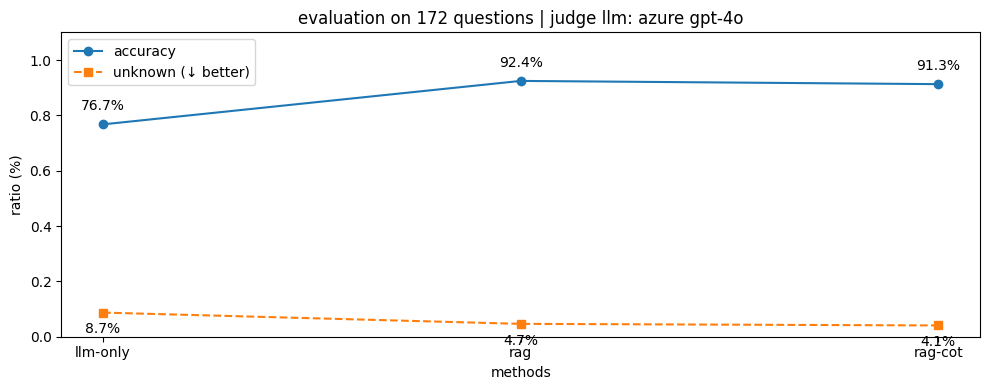

In [15]:
subset = slice(0, 172)
rag_loaded = load_results_json("rag_results.json")[subset]
llm_loaded = load_results_json("llm_only_results.json")[subset]
rag_cot_loaded = load_results_json("rag_cot_results.json")[subset]

rag_preds = [r['predicted_answer'] for r in rag_loaded]
rag_truth = [r['correct_answer'] for r in rag_loaded]
llm_preds = [r['predicted_answer'] for r in llm_loaded]
llm_truth = [r['correct_answer'] for r in llm_loaded]
rag_cot_preds = [r['predicted_answer'] for r in rag_cot_loaded]
rag_cot_truth = [r['correct_answer'] for r in rag_cot_loaded]

rag_metrics = evaluate_answers_with_unknowns(rag_preds, rag_truth)
llm_metrics = evaluate_answers_with_unknowns(llm_preds, llm_truth)
rag_cot_metrics = evaluate_answers_with_unknowns(rag_cot_preds, rag_cot_truth)

with open("rag_metrics.json", "w") as f:
    json.dump(rag_metrics, f, indent=2)
with open("llm_metrics.json", "w") as f:
    json.dump(llm_metrics, f, indent=2)
with open("rag_cot_metrics.json", "w") as f:
    json.dump(rag_cot_metrics, f, indent=2)

labels = ["accuracy"]
methods = ["llm-only", "rag", "rag-cot"]
metric_matrix = [
    [llm_metrics[k] for k in labels],
    [rag_metrics[k] for k in labels],
    [rag_cot_metrics[k] for k in labels]
]

plt.figure(figsize=(10,4))
for i, label in enumerate(labels):
    plt.plot(methods, [metric_matrix[0][i], metric_matrix[1][i], metric_matrix[2][i]], "o-", label=label)
    for j, method in enumerate(methods):
        plt.annotate(f"{metric_matrix[j][i]:.1%}", (method, metric_matrix[j][i]), textcoords="offset points", xytext=(0,10), ha="center")

unknown_vals = [
    llm_metrics["unknown_count"] / llm_metrics["total_count"], 
    rag_metrics["unknown_count"] / rag_metrics["total_count"],
    rag_cot_metrics["unknown_count"] / rag_cot_metrics["total_count"]
]
plt.plot(methods, unknown_vals, "s--", label="unknown (↓ better)", color="tab:orange")
for i, method in enumerate(methods):
    plt.annotate(f"{unknown_vals[i]:.1%}", (method, unknown_vals[i]), textcoords="offset points", xytext=(0,-15), ha="center")

plt.ylim(0, 1.1)
plt.ylabel("ratio (%)")
plt.xlabel("methods")
plt.title(f"evaluation on {len(rag_loaded)} questions | judge llm: azure gpt-4o")
plt.legend()
plt.tight_layout()
plt.show()